In [13]:
import sys
import os
sys.path.append(os.path.abspath('../'))
sys.path.append(os.path.abspath(''))

import pandas as pd
import numpy as np
import jsonlines
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from facebook_hateful_memes_detector.utils import read_json_lines_into_df
from facebook_hateful_memes_detector.preprocessing import clean_text


In [2]:
dev = read_json_lines_into_df('../data/dev.jsonl')
train = read_json_lines_into_df('../data/train.jsonl')
test = read_json_lines_into_df('../data/test.jsonl')

In [3]:
dev.shape
train.shape
test.shape

(500, 4)

(8500, 4)

(1000, 3)

In [4]:
train.label.value_counts()
dev.label.value_counts()

0    5450
1    3050
Name: label, dtype: int64

1    250
0    250
Name: label, dtype: int64

In [16]:
from polyglot.text import Text
preds = train.text.apply(clean_text).head(512).apply(lambda x: Text(x).polarity).values
truths = train.label.head(512).values
preds = (1 - preds)/2

list(zip(truths,preds))
np.corrcoef(truths,preds)


[(0, 0.5),
 (0, 0.33333333333333337),
 (0, 0.5),
 (0, 0.5),
 (0, 0.0),
 (0, 0.0),
 (0, 0.33333333333333337),
 (0, 1.0),
 (0, 0.5),
 (0, 0.33333333333333337),
 (1, 1.0),
 (0, 0.5),
 (1, 1.0),
 (0, 0.5),
 (0, 0.5),
 (0, 0.0),
 (0, 0.5),
 (0, 0.0),
 (0, 0.5),
 (0, 1.0),
 (0, 0.0),
 (0, 1.0),
 (0, 0.5),
 (0, 0.5),
 (0, 0.5),
 (0, 0.0),
 (0, 1.0),
 (1, 0.0),
 (0, 1.0),
 (0, 1.0),
 (1, 0.0),
 (0, 0.0),
 (0, 1.0),
 (0, 1.0),
 (0, 0.0),
 (0, 0.0),
 (0, 0.5),
 (0, 0.5),
 (0, 0.0),
 (0, 0.0),
 (0, 1.0),
 (0, 0.5),
 (0, 0.5),
 (0, 1.0),
 (0, 1.0),
 (0, 0.5),
 (0, 1.0),
 (0, 0.5),
 (1, 0.5),
 (0, 1.0),
 (0, 0.6),
 (0, 0.0),
 (1, 1.0),
 (0, 1.0),
 (0, 0.5),
 (0, 0.0),
 (0, 0.0),
 (0, 0.0),
 (0, 0.5),
 (0, 0.5),
 (0, 0.5),
 (1, 0.5),
 (1, 1.0),
 (0, 0.5),
 (0, 1.0),
 (1, 1.0),
 (0, 1.0),
 (0, 0.0),
 (0, 0.5),
 (1, 1.0),
 (0, 0.5),
 (0, 0.5),
 (0, 0.0),
 (0, 0.5),
 (0, 0.5),
 (0, 0.5),
 (0, 1.0),
 (0, 1.0),
 (0, 0.5),
 (0, 0.5),
 (0, 0.5),
 (0, 0.5),
 (0, 0.5),
 (1, 1.0),
 (0, 1.0),
 (0, 0.5),
 (1, 1

array([[1.        , 0.20529369],
       [0.20529369, 1.        ]])

In [5]:
columns = train.columns
print(columns)

Index(['id', 'img', 'label', 'text'], dtype='object')


In [6]:
train.shape

(8500, 4)

In [ ]:
import stanza
snlp = stanza.Pipeline('en', processors='tokenize,pos,lemma,depparse,ner', use_gpu=True, pos_batch_size=3000)

texts = train.text.apply(clean_text)

In [36]:
import fasttext
tokenised_lengths = train.text.apply(clean_text).apply(fasttext.tokenize).apply(len)
tokenised_lengths[tokenised_lengths > 64]
sum(tokenised_lengths > 64)
tokenised_lengths.describe()
train[tokenised_lengths > 64].text.values

3954    68
4958    69
6663    70
7581    69
8242    67
Name: text, dtype: int64

5

count    8500.000000
mean       12.160118
std         7.107391
min         1.000000
25%         7.000000
50%        11.000000
75%        16.000000
max        70.000000
Name: text, dtype: float64

array(['have you ever studied the history of the jews? did you know that they have always banded together as a tribe, infiltrated governments, monopolized the financial systems of nations instigated wars and intentionally created chaos in societies? the jews have mass murdered millions of non- jews over the centuries they have seized control of the media so you will never find out study the history of the jews!',
       'president trump accused of sexual assault right before the election clarence thomas accused sexual harassment right before the election right before getting voted in by the senate roy moore accused of sexual assault right before senate election in alabama brett kavanaugh accused of sexual assault right before getting voted in by the senate still convinced that the accusers are telling the truth? bret e macgregor monday at 8:34 pm',
       'bruder you killed me so the jew could control your media so the jews could control your banks so the jews control you money so the 

In [28]:
# Train a decision tree classifier only on length
# Word Lengths as a feature into an LSTM?

# train.groupby(np.digitize(tokenised_lengths, [0, 10, 15, 35, 45, 55, 75], right=True))[["label"]].mean()
# train.groupby(np.digitize(tokenised_lengths, list(range(0, 76, 5)), right=True))[["label"]].mean()
f1 = np.digitize(tokenised_lengths, [0, 10, 15, 35, 45, 55, 75], right=True)
f2 = tokenised_lengths
f3 = np.digitize(tokenised_lengths, list(range(0, 76, 5)), right=True)
X = np.array([f1, f2, f3]).T
y = train.label.values

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

clf = DecisionTreeClassifier(random_state=0, max_depth=6, min_samples_leaf=4, max_features=3)
np.mean(cross_val_score(clf, X, y, scoring='roc_auc', cv=5))


0.565851255827944

In [ ]:
# Use each word Lengths
# Use NLTK POS
# Use NLTK NER
# Use Glove 

In [8]:
from transformers import AlbertModel, AlbertTokenizer
import torch
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
tokenised_lengths = train.text.apply(lambda x: tokenizer.encode(x, add_special_tokens=True)).apply(len)
tokenised_lengths.describe()

count    8500.000000
mean       16.795059
std         9.058886
min         3.000000
25%        10.000000
50%        15.000000
75%        21.000000
max        87.000000
Name: text, dtype: float64

In [ ]:
texts = list(train.text.values)
type(texts)
texts

In [35]:
def mapper(texts):
    m = lambda x: tokenizer.encode_plus(x, add_special_tokens=True, pad_to_max_length=True, max_length=128)
    input_ids, attention_mask = zip(*[(d['input_ids'], d['attention_mask']) for d in map(m, texts)])
    return torch.tensor(input_ids), torch.tensor(attention_mask)
input_ids, attention_mask = mapper(texts[:64])
input_ids.shape
attention_mask.shape

torch.Size([64, 128])

torch.Size([64, 128])

In [36]:
model = AlbertModel.from_pretrained('albert-base-v2')

In [38]:
outputs = model(input_ids, attention_mask=attention_mask)
outputs[0].shape
outputs[1].shape

torch.Size([64, 128, 768])

torch.Size([64, 768])

In [50]:
import torch.nn as nn
import torch
conv1d = nn.Conv1d(128, 16, 1, stride=1, padding=0, dilation=1, groups=8, bias=False, padding_mode='zeros')
conv1d(outputs[0]).shape


torch.Size([64, 16, 768])

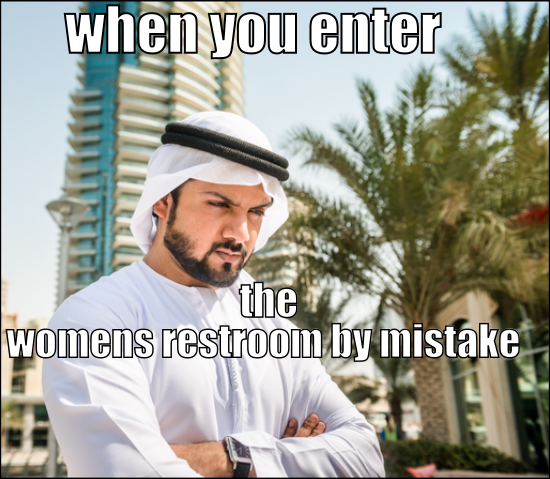

In [6]:
from PIL import Image
input_image = Image.open("../data/img/62358.png")
input_image.copy()